<a href="https://colab.research.google.com/github/JoDeMiro/Keras/blob/main/05_Keras_Time_Series_Forcasting_via_1D_Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Bevezetés a TensorFlow regresszió használatába.

Nem utolsó sorban azért készítem el ezt a notebookot mert elképesztően jó template.

In [1]:
#@title Leírás
# Ha valamilyen regresszó jellegű problémát szeretnél megoldani.
# Ami azt jelenti, hogy a bemeneti és a kimeneti válozó is folytonos, nem kategóriális.
#
# https://www.github.com
#
# Ez a kis program a regressziós problémák megoldásába nyújt bevezetést.
# Egyébként ez a kód a TensorFlow honlapjáról származik.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Time Series Prediction via 1D Convolution: Value($Y_t$) -> Value($X_{t+1})$

<table class="buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/JoDeMiro/Face" /><img src="https://github.com/JoDeMiro/Data/raw/main/Bucket/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Egy nagyon érdekes kísérletet teszek. Van egy sinus hullámom és megpróbálom megbecsólni $t+1$ időpontban vett értékét $t$ és vagy $t, t-1$ időpontban vett értéke alapján.

Ha ez sikerül akkor írok egy függvényt ami az így kapott becsléseket képes a távoli jövőbe (tetszőleges $t+n$ időpontra is elvégezni.

Ha ezzel is megvagyok, akkor a következő becslésen nem csak $t+1$ időpontra, hanem egyszerre több változóra $t+1, t+2, ..., t+n$ is megkísérlem és megnézem, hogy így milyen becsléseket kapok.

[run](#run)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make NumPy printouts easier to read.
np.set_printoptions(precision=8, suppress=True)

# Make experiment repeateable
np.random.seed(1)

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# Make experiment repeatable
# tf.random.set_seed(1)

print(tf.__version__)

2.7.0


In [5]:
from keras import backend as K

if K.backend() == "tensorflow":
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '':
        device_name = "None"
    print('Using TensorFlow version:', tf.__version__, ', GPU:', device_name)

Using TensorFlow version: 2.7.0 , GPU: None


## Generate Sinus function

Egyszerűen létrehozok egy sinusz függvényt. A potenciális veszély abban lenne, ha az idő alapján akarnám becsülni az értékét, hogy az idő nincs 0-1 közé normalizálva. De ebben az esetben erről nincs szó mert $Y_t = Y_{t-1}$ becslést fogok végezni, és $Y$ mindíg -1, +1 közé van normalizálva.


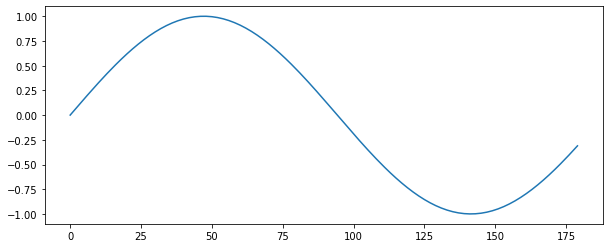

In [6]:
time = np.arange(0, 180, 1)

y = np.sin(time/30)

plt.figure(figsize=(10, 4))
plt.plot(y)
plt.show()

## Create lags

Hogyan lehet az adatokat egy változó esetén olyan formára hozni, hogy azok megfelelő bemenetei legyen az 1Dimenziós Convoluciós Hálónak.

In [7]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [8]:
_X, _y = split_sequence(y, 3)

In [9]:
print(_X.shape, _y.shape)

print(_X[0:5,:], _y[0:5])

(177, 3) (177,)
[[0.         0.03332716 0.06661729]
 [0.03332716 0.06661729 0.09983342]
 [0.06661729 0.09983342 0.13293862]
 [0.09983342 0.13293862 0.16589613]
 [0.13293862 0.16589613 0.19866933]] [0.09983342 0.13293862 0.16589613 0.19866933 0.23122181]


In [10]:
demo_timeseries = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [11]:
_demo_X, _demo_y = split_sequence(demo_timeseries, 3)

for i in range(len(_demo_X)):
	print(_demo_X[i], _demo_y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90


## CNN 1D

A bemenetet ilyen forára kell hozzni

```
[samples, timesteps, features]

samples = 6  # vagy ahány megfigyelési esetünk van - max(lag)

timestamp = 3 # vagyis a lag-ok száma

features = 1 # vagyis ahány önneáló idősorunk van ez esetben 1
```



In [12]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
n_steps = _demo_X.shape[1]
X = _demo_X.reshape((_demo_X.shape[0], _demo_X.shape[1], n_features))

print(n_features)
print(n_steps)
print(X.shape)

1
3
(6, 3, 1)


In [13]:
input  = X
output = _demo_y

print(input.shape)
print(output.shape)

(6, 3, 1)
(6,)


In [14]:
# define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,493
Trainable params: 3,493
Non-trainable params: 0
______________________________________________________

In [15]:
# fit model
# history = model.fit(input, output, verbose=0, batch_size = 32, epochs=300) # ------> batch_size = 32 (default)

history = model.fit(input, output, verbose=0, epochs=900)                    # ------> batch_size = 32 (default)

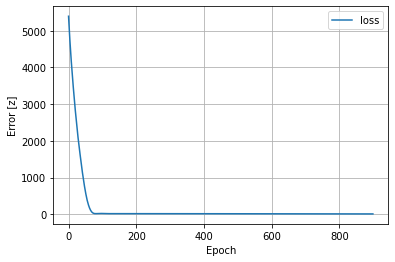

In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [17]:
# demonstrate prediction
_demo_X_input = np.array([70, 80, 90])

_demo_X_input = _demo_X_input.reshape((1, n_steps, n_features))

_demo_y_predicted = model.predict(_demo_X_input, verbose=1)

print(_demo_y_predicted)

1/1 [==============================] - 0s 86ms/step
[[105.54541]]


## CNN 1D - Ugyan ez kicsit átírva

A bemenetet ilyen forára kell hozzni

```
[samples, lags, features]

samples  = 6 # vagy ahány megfigyelési esetünk van - max(lag)

lags     = 3 # vagyis a lag-ok száma

features = 1 # vagyis ahány önneáló idősorunk van ez esetben 1
```



In [18]:
# reshape from [samples, lags] into [samples, lags, features]
n_features = 1
n_lags = _demo_X.shape[1]
n_observation = _demo_X.shape[0]

X = _demo_X.reshape((n_observation, n_lags, n_features))

print(n_features)
print(n_lags)
print(X.shape)

1
3
(6, 3, 1)


In [19]:
input  = X
output = _demo_y

print(input.shape)
print(output.shape)

input_shape = (n_lags, n_features) # (3, 1)

print(input_shape)

(6, 3, 1)
(6,)
(3, 1)


In [20]:
# define model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(n_lags, n_features)))

# model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'))

model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2, 64)             192       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                3250      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,493
Trainable params: 3,493
Non-trainable params: 0
____________________________________________________

In [21]:
# fit model
# history = model.fit(input, output, verbose=0, batch_size = 32, epochs=300)

history = model.fit(input, output, verbose=0, epochs=900)

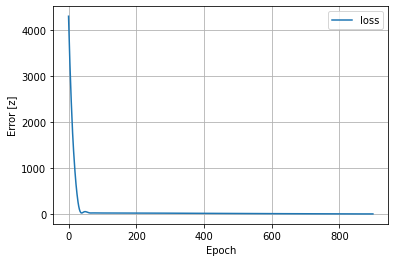

In [22]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [23]:
# demonstrate prediction
_demo_X_input = np.array([70, 80, 90])

_demo_X_input = _demo_X_input.reshape((1, n_lags, n_features))

_demo_y_predicted = model.predict(_demo_X_input, verbose=1)

print(_demo_y_predicted)

1/1 [==============================] - 0s 55ms/step
[[100.65218]]


## CNN 1D - Ugyan ez még jobban átírva

A bemenetet ilyen forára kell hozzni

```
[samples, lags, features]

samples  = 6 # vagy ahány megfigyelési esetünk van - max(lag)

lags     = 3 # vagyis a lag-ok száma

features = 1 # vagyis ahány önneáló idősorunk van ez esetben 1
```

Ne felejtsük 2D képek esetén a bemenet ilyen formára van hozva:

```
[n_of_samples, height, width, chanel] # [100, 28, 28, 3]
```

Ez a mi esetünkben 1D esetén most így néz ki

```
[n_of_samples, lags, 'chanel'] # [6, 3, 1]
```




In [24]:
# reshape from [samples, lags] into [samples, lags, features]
n_features = 1
n_lags = _demo_X.shape[1]
n_observation = _demo_X.shape[0]

X = _demo_X.reshape((n_observation, n_lags, n_features))

print(n_features)
print(n_lags)
print(X.shape)

1
3
(6, 3, 1)


In [25]:
input  = X
output = _demo_y

print(input.shape)
print(output.shape)

input_shape = (n_lags, n_features) # (3, 1)

print(input_shape)

(6, 3, 1)
(6,)
(3, 1)


In [26]:
# define model

input_shape = input_shape
filters = 64
kernel_size = 2
activation = 'relu'
pool_size = 2
output_shape = 1


model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(n_lags, n_features)))

model.add(tf.keras.layers.Conv1D(filters=filters,
                                 kernel_size=kernel_size,
                                 activation=activation))

model.add(tf.keras.layers.MaxPooling1D(pool_size=pool_size))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(output_shape))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2, 64)             192       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                3250      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,493
Trainable params: 3,493
Non-trainable params: 0
____________________________________________________

In [27]:
# fit model
# history = model.fit(input, output, verbose=0, batch_size = 32, epochs=300)

history = model.fit(input, output, verbose=0, epochs=900)

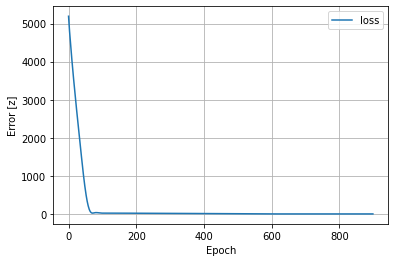

In [28]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [29]:
# demonstrate prediction
_demo_X_input = np.array([70, 80, 90])

_demo_X_input = _demo_X_input.reshape((1, n_lags, n_features))

_demo_y_predicted = model.predict(_demo_X_input, verbose=1)

print(_demo_y_predicted)

1/1 [==============================] - 0s 61ms/step
[[101.038925]]


## CNN 1D - Ugyan ez Sinus adatokon

A bemenetet ilyen forára kell hozzni

```
[samples, lags, features]

samples  = 177 # vagy ahány megfigyelési esetünk van - max(lag)

lags     = 3   # vagyis a lag-ok száma

features = 1   # vagyis ahány önneáló idősorunk van ez esetben 1
```

Ne felejtsük 2D képek esetén a bemenet ilyen formára van hozva:

```
[n_of_samples, height, width, chanel] # [100, 28, 28, 3]
```

Ez a mi esetünkben 1D esetén most így néz ki

```
[n_of_samples, lags, 'chanel'] # [177, 3, 1]
```




In [30]:
# reshape from [samples, lags] into [samples, lags, features]
n_features = 1
n_lags = _X.shape[1]
n_observation = _X.shape[0]

X = _X.reshape((n_observation, n_lags, n_features))

print(n_features)
print(n_lags)
print(X.shape)

1
3
(177, 3, 1)


In [31]:
input  = X
output = _y

print(input.shape)
print(output.shape)

input_shape = (n_lags, n_features) # (3, 1)

print(input_shape)

(177, 3, 1)
(177,)
(3, 1)


In [32]:
# define model

input_shape = input_shape
filters = 64
kernel_size = 2
activation = 'relu'
pool_size = 2
output_shape = 1


model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(n_lags, n_features)))

model.add(tf.keras.layers.Conv1D(filters=filters,
                                 kernel_size=kernel_size,
                                 activation=activation))

model.add(tf.keras.layers.MaxPooling1D(pool_size=pool_size))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(output_shape))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 2, 64)             192       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                3250      
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,493
Trainable params: 3,493
Non-trainable params: 0
____________________________________________________

In [33]:
# fit model
# history = model.fit(input, output, verbose=0, batch_size = 32, epochs=300)

history = model.fit(input, output, verbose=0, epochs=900)

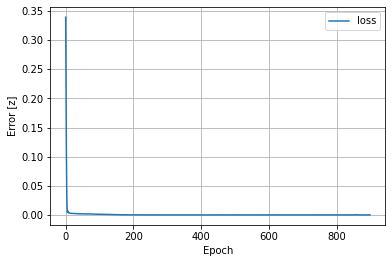

In [34]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [35]:
print(_X[-1,:])
print(_y[-1])

[-0.4045792  -0.37387666 -0.34275875]
-0.3112600313131545


In [36]:
# demonstrate prediction
_demo_X_input = np.array([-0.4045792 , -0.37387666, -0.34275875])

_demo_X_input = _demo_X_input.reshape((1, n_lags, n_features))

_demo_y_predicted = model.predict(_demo_X_input, verbose=1)

print(_demo_y_predicted)

1/1 [==============================] - 0s 57ms/step
[[-0.31181476]]


In [37]:
_y_predicted = model.predict(_X, verbose=1)

6/6 [==============================] - 0s 3ms/step


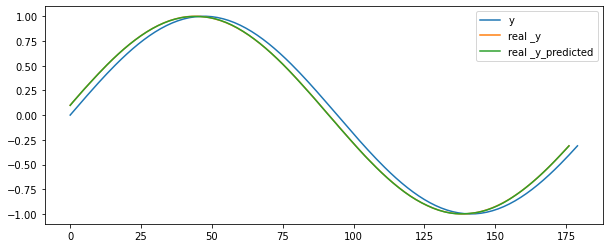

In [38]:
plt.subplots(figsize=(10, 4))
plt.plot(y, label = 'y')
plt.plot(_y, label = 'real _y')
plt.plot(_y_predicted, label = 'real _y_predicted')
plt.legend()
plt.show()

In [39]:
model.get_weights()

[array([[[ 0.16916674, -0.10180303, -0.18420221, -0.09691007,
          -0.209321  ,  0.14310177,  0.16516504, -0.23941238,
          -0.08532254,  0.18774821,  0.13845538, -0.14774412,
          -0.13733229, -0.10071371,  0.22664505,  0.03211383,
           0.19051023,  0.1280045 , -0.0716814 , -0.20444718,
          -0.00288247, -0.14434701, -0.10622477,  0.21053821,
           0.02559506,  0.03596772,  0.15768425,  0.13596562,
          -0.22105339, -0.08355768, -0.19563423, -0.08719926,
           0.08974316, -0.08938441, -0.08945316,  0.1789715 ,
           0.06882621,  0.1190265 ,  0.025111  ,  0.177222  ,
          -0.09035061, -0.014783  , -0.16509098, -0.1810289 ,
           0.20317982,  0.1610938 , -0.23396634, -0.14748028,
           0.16045676,  0.09630176, -0.2274024 , -0.03680611,
           0.17089768, -0.01193463,  0.06211543,  0.19395009,
           0.12850632, -0.0973547 ,  0.20952044,  0.17809613,
           0.07561507,  0.02941404, -0.2278806 ,  0.08765744]],
 
    

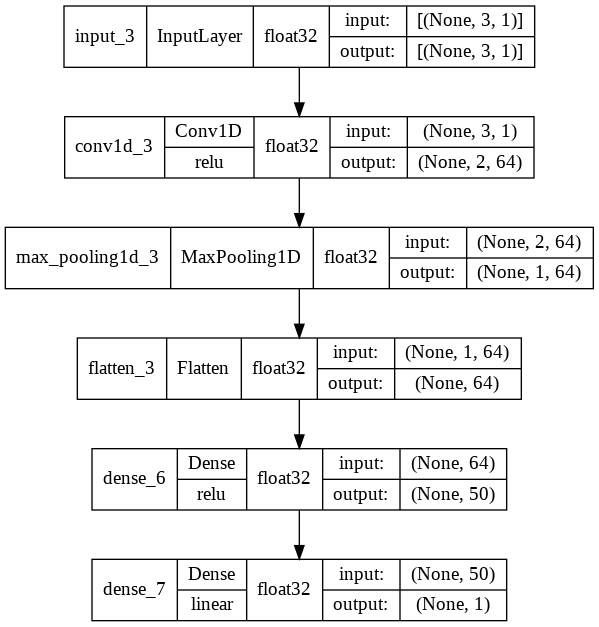

In [40]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True, expand_nested=True)

## Forecast

Kezdetleges és nem teljesen jó

(178, 3) (178,)
(179, 3) (179,)
(180, 3) (180,)
(181, 3) (181,)
(182, 3) (182,)
(183, 3) (183,)
(184, 3) (184,)
(185, 3) (185,)
(186, 3) (186,)
(187, 3) (187,)
(188, 3) (188,)
(189, 3) (189,)
(190, 3) (190,)
(191, 3) (191,)
(192, 3) (192,)
(193, 3) (193,)
(194, 3) (194,)
(195, 3) (195,)
(196, 3) (196,)
(197, 3) (197,)
(198, 3) (198,)
(199, 3) (199,)
(200, 3) (200,)
(201, 3) (201,)
(202, 3) (202,)
(203, 3) (203,)
(204, 3) (204,)
(205, 3) (205,)
(206, 3) (206,)
(207, 3) (207,)
(208, 3) (208,)
(209, 3) (209,)
(210, 3) (210,)
(211, 3) (211,)
(212, 3) (212,)
(213, 3) (213,)
(214, 3) (214,)
(215, 3) (215,)
(216, 3) (216,)
(217, 3) (217,)
(218, 3) (218,)
(219, 3) (219,)
(220, 3) (220,)
(221, 3) (221,)
(222, 3) (222,)
(223, 3) (223,)
(224, 3) (224,)
(225, 3) (225,)
(226, 3) (226,)
(227, 3) (227,)


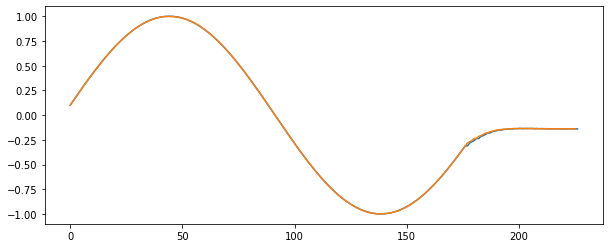

In [41]:
# Forecast

foreward = 50

_input = input.copy()
_bemenet = y.copy()

for i in range(foreward):
  # print(_input.shape)
  # print(_bemenet.shape)
  y_t_1_pred = model.predict(_input)
  _bemenet = np.append(_bemenet, y_t_1_pred[-1])
  _X, _y = split_sequence(_bemenet, 3)
  print(_X.shape, _y.shape)
  X = _X.reshape((_X.shape[0], _X.shape[1], n_features))
  _input = _X.copy()
  
plt.figure(figsize=(10, 4))
plt.plot(_y)
plt.plot(y_t_1_pred)
plt.show()

## Multivariate CNN Models

In [42]:

seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])

# out_seq = np.array([seq1[i]+seq2[i] for i in range(len(seq1))])

out_seq = seq1 + seq2

out_seq

array([ 25,  45,  65,  85, 105, 125, 145, 165, 185])

In [43]:
stack = np.vstack((seq1, seq2, out_seq)).T

stack

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

Ezt kéne olyan formára hozni, hogy:

```
[ 10,  15],
[ 20,  25],
[ 30,  35],
```
és a hozzá tartozó kimenet
```
[65]
```
Vagy valami ilyesmi.


In [44]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [45]:
stack.shape

(9, 3)

In [46]:
n_steps = 3

_X, _y = split_sequences(stack, n_steps)
print(_X.shape, _y.shape)

for i in range(len(_X)):
	print(_X[i], _y[i])

(7, 3, 2) (7,)
[[10 15]
 [20 25]
 [30 35]] 65
[[20 25]
 [30 35]
 [40 45]] 85
[[30 35]
 [40 45]
 [50 55]] 105
[[40 45]
 [50 55]
 [60 65]] 125
[[50 55]
 [60 65]
 [70 75]] 145
[[60 65]
 [70 75]
 [80 85]] 165
[[70 75]
 [80 85]
 [90 95]] 185


In [47]:
n_features = _X.shape[2]

In [48]:
# define model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

In [49]:
input = _X
output = _y

In [50]:
# fit model

history = model.fit(input, output, verbose=0, epochs=900)                    # ------> batch_size = 32 (default)

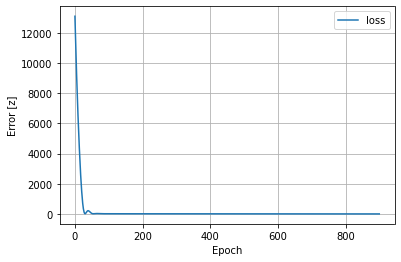

In [51]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [52]:
# demonstrate prediction
_X_input = np.array([[80, 85], [90, 95], [100, 105]])

_X_input = _X_input.reshape((1, n_steps, n_features))

_y_predicted = model.predict(_X_input, verbose=1)

print(_y_predicted)

1/1 [==============================] - 0s 70ms/step
[[205.94865]]


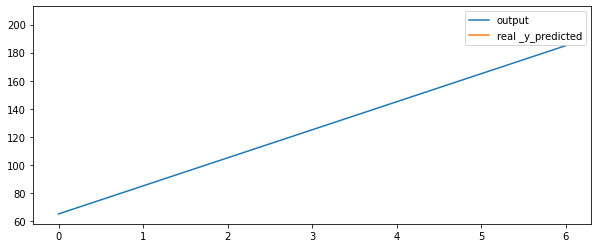

In [53]:
plt.subplots(figsize=(10, 4))
plt.plot(output, label = 'output')
plt.plot(_y_predicted, label = 'real _y_predicted')
plt.legend()
plt.show()

## Ugyan ez Functiona API segítségével

In [54]:
# define model
input_layer = tf.keras.layers.Input(shape=(n_steps, n_features))

cnn_layer_1 = tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input_layer)
pool_layer_1 = tf.keras.layers.MaxPool1D(pool_size=2)(cnn_layer_1)
flatten_layer_1 = tf.keras.layers.Flatten()(pool_layer_1)
dense_layer_1 = tf.keras.layers.Dense(units=50, activation='relu')(flatten_layer_1)
output_layer_1 = tf.keras.layers.Dense(units=1)(dense_layer_1)


model = tf.keras.Model(inputs=input_layer, outputs=output_layer_1)

model.compile(optimizer='adam', loss='mse')

In [55]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3, 2)]            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 50)                3250      
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                             

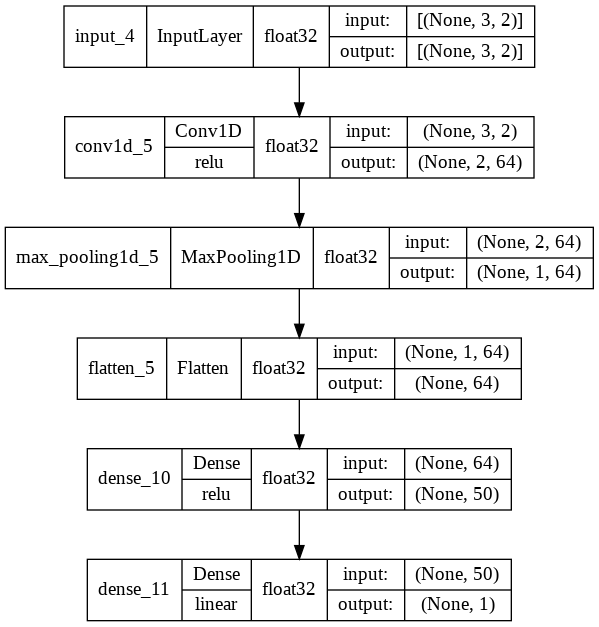

In [56]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, show_layer_activations=True)

In [57]:
history = model.fit(input, output, verbose=0, epochs=900)

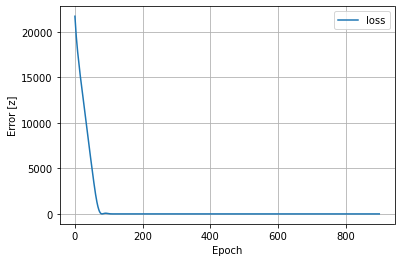

In [58]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [59]:
# demonstrate prediction
_X_input = np.array([[80, 85], [90, 95], [100, 105]])

_X_input = _X_input.reshape((1, n_steps, n_features))

_y_predicted = model.predict(_X_input, verbose=1)

print(_y_predicted)

1/1 [==============================] - 0s 56ms/step
[[208.53198]]


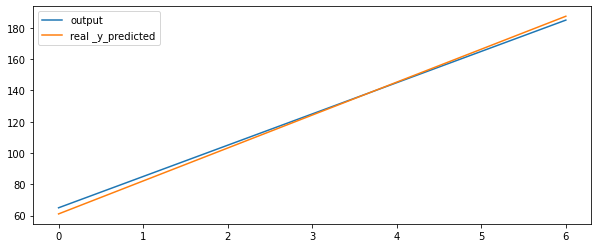

In [60]:
_y_predicted = model.predict(input)

plt.subplots(figsize=(10, 4))
plt.plot(output, label = 'output')
plt.plot(_y_predicted, label = 'real _y_predicted')
plt.legend()
plt.show()

## 2 Input 1D CNN

Ezt lehet variálni azzal, hogy a két bemenetnek két külön modelt hozunk létre, amelyeket a végén összefűzünk és így tanítjuk őket. Ennek az az értelme, hogy változónként más más beállításokat, rétegeket, filtereket tudunk eszközölni, ha ezt a rendszer megkívánja.

In [61]:
n_features = 1

In [62]:
# define model for input 1

input_layer_1 = tf.keras.layers.Input(shape=(n_steps, n_features))

cnn_layer_1 = tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input_layer_1)
pool_layer_1 = tf.keras.layers.MaxPool1D(pool_size=2)(cnn_layer_1)
flatten_layer_1 = tf.keras.layers.Flatten()(pool_layer_1)

# define model for input 2

input_layer_2 = tf.keras.layers.Input(shape=(n_steps, n_features))

cnn_layer_2 = tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input_layer_2)
pool_layer_2 = tf.keras.layers.MaxPool1D(pool_size=2)(cnn_layer_2)
flatten_layer_2 = tf.keras.layers.Flatten()(pool_layer_2)

# merge input models

merge_layer = tf.keras.layers.concatenate([flatten_layer_1, flatten_layer_2])
dense_layer = tf.keras.layers.Dense(50, activation='relu')(merge_layer)
output_layer = tf.keras.layers.Dense(1)(dense_layer)

# Create
model = tf.keras.Model(inputs=[input_layer_1, input_layer_2], outputs=output_layer)

# Compile
model.compile(optimizer='adam', loss='mse')

In [63]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 2, 64)        192         ['input_5[0][0]']                
                                                                                                  
 conv1d_7 (Conv1D)              (None, 2, 64)        192         ['input_6[0][0]']                
                                                                                            

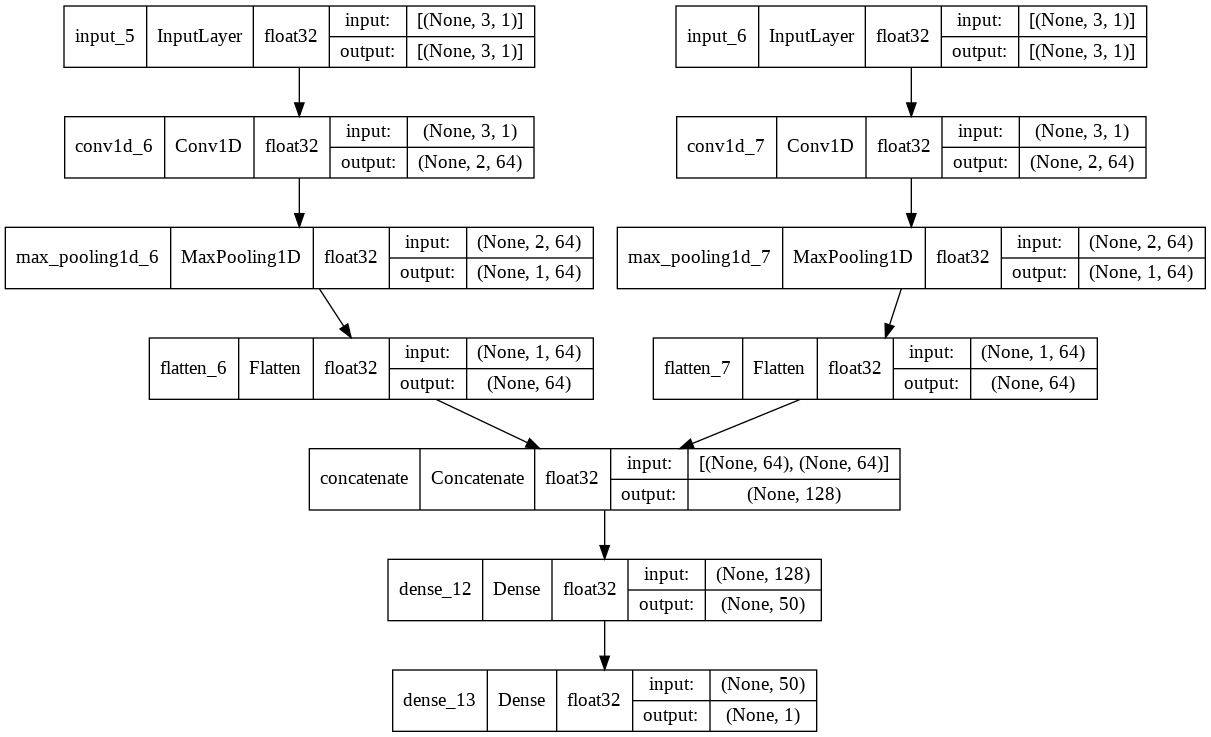

In [64]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

A lényeg, hogy mielött illesztenénk ezt a modelt, ez a model két bemenetet vár, ugyhogy fogom az adataimat és függőlegesen ketté vágom, továbbá az `n_feautres = 1` különben nem tudja megemészteni a model.

In [65]:
# one time series per head
n_features = 1

# separate input data
_X1 = _X[:, :, 0].reshape(_X.shape[0], _X.shape[1], n_features)
_X2 = _X[:, :, 1].reshape(_X.shape[0], _X.shape[1], n_features)

print(_X1.shape)
print(_X2.shape)

(7, 3, 1)
(7, 3, 1)


In [66]:
history = model.fit(x=[_X1, _X2], y=_y, verbose=0, epochs=900)

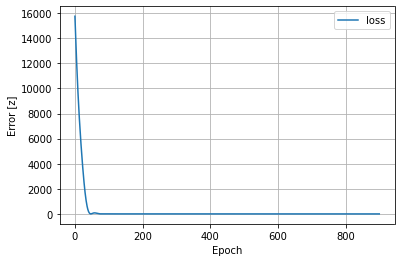

In [67]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

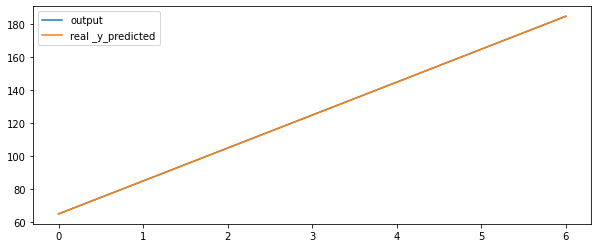

In [68]:
_y_predicted = model.predict([_X1, _X2])

plt.subplots(figsize=(10, 4))
plt.plot(output, label = 'output')
plt.plot(_y_predicted, label = 'real _y_predicted')
plt.legend()
plt.show()

## Ugyan ez 2 Input 1D CNN Functional API

De most egy bonyolultabb és össszetett szinusz hullám esetében.

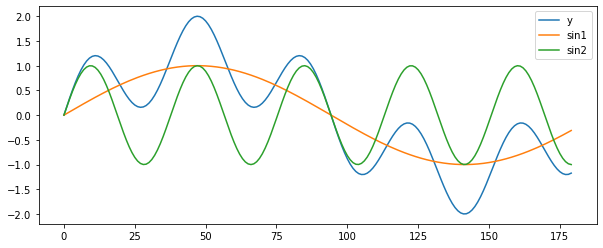

In [69]:
time = np.arange(0, 180, 1)

sin1 = np.sin(time/30)
sin2 = np.sin(time/6)

y = 1.2 * sin1 + 0.8 * sin2

stack = np.vstack((sin1, sin2, y)).T

plt.figure(figsize=(10, 4))
plt.plot(y, label = 'y')
plt.plot(stack[:,0], label = 'sin1')
plt.plot(stack[:,1], label = 'sin2')
plt.legend()
plt.show()

In [70]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [71]:
n_steps = 3

In [72]:
_X, _y = split_sequences(stack, n_steps)

In [73]:
n_features = _X.shape[2]          # ----> ezt majd később felülírom

In [74]:
n_features = 1

In [75]:
# define model for input 1

input_layer_1 = tf.keras.layers.Input(shape=(n_steps, n_features))

cnn_layer_1 = tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input_layer_1)
pool_layer_1 = tf.keras.layers.MaxPool1D(pool_size=2)(cnn_layer_1)
flatten_layer_1 = tf.keras.layers.Flatten()(pool_layer_1)

# define model for input 2

input_layer_2 = tf.keras.layers.Input(shape=(n_steps, n_features))

cnn_layer_2 = tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input_layer_2)
pool_layer_2 = tf.keras.layers.MaxPool1D(pool_size=2)(cnn_layer_2)
flatten_layer_2 = tf.keras.layers.Flatten()(pool_layer_2)

# merge input models

merge_layer = tf.keras.layers.concatenate([flatten_layer_1, flatten_layer_2])
dense_layer = tf.keras.layers.Dense(50, activation='relu')(merge_layer)
output_layer = tf.keras.layers.Dense(1)(dense_layer)

# Create
model = tf.keras.Model(inputs=[input_layer_1, input_layer_2], outputs=output_layer)

# Compile
model.compile(optimizer='adam', loss='mse')

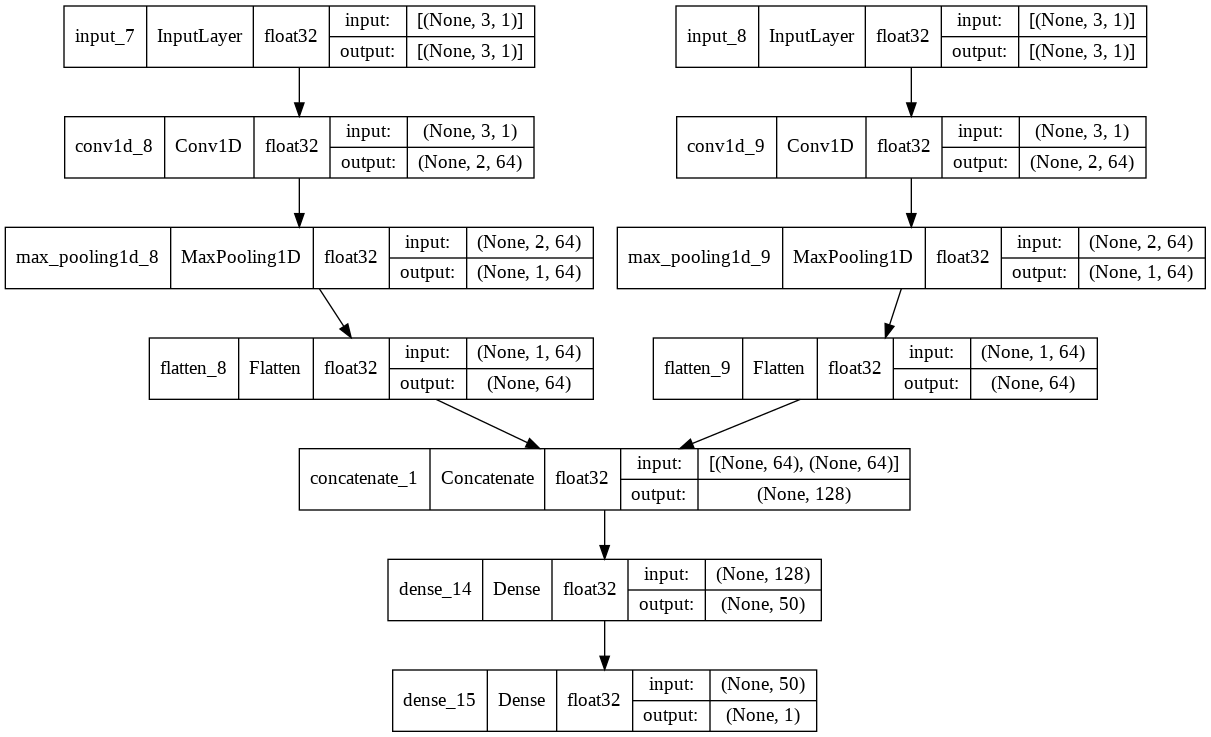

In [76]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

A lényeg, hogy mielött illesztenénk ezt a modelt, ez a model két bemenetet vár, ugyhogy fogom az adataimat és függőlegesen ketté vágom, továbbá az `n_feautres = 1` különben nem tudja megemészteni a model.



In [77]:
# one time series per head
n_features = 1

# separate input data
_X1 = _X[:, :, 0].reshape(_X.shape[0], _X.shape[1], n_features)
_X2 = _X[:, :, 1].reshape(_X.shape[0], _X.shape[1], n_features)

print(_X1.shape)
print(_X2.shape)

(178, 3, 1)
(178, 3, 1)


In [78]:
history = model.fit(x=[_X1, _X2], y=_y, verbose=0, epochs=300)

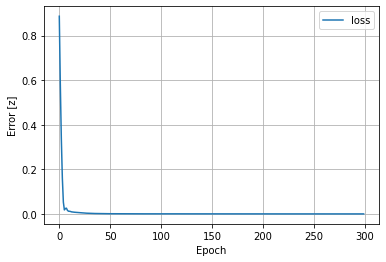

In [79]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

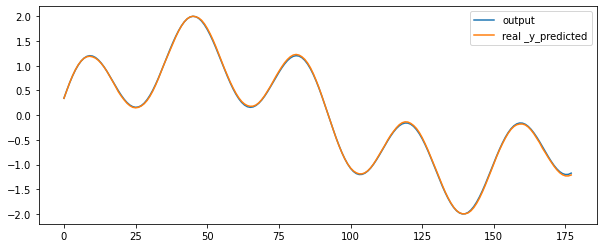

In [80]:
_y_predicted = model.predict([_X1, _X2])

plt.subplots(figsize=(10, 4))
plt.plot(_y, label = 'output')
plt.plot(_y_predicted, label = 'real _y_predicted')
plt.legend()
plt.show()

## Na van ennek egy még durvább változata is

Ami még jól jöhet a Optimizer fejleszétsénél, ha arról van szó, hogy nem csak

`average latency` érétkét akaraom becsülni, hanem ezzel párhuzamosan mondjuk a `felső 80%` vagy a `felső 95%` értékét.

Jelenleg ez még nincs tervben de egy blue-print segíthet a későbbi megvalósításban.

A becsült változók és a becsült függvény ugyan az mint korábban : két sinusz függvény összege.


In [81]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [82]:
n_steps = 3
n_features = 3

In [83]:
_X, _y = split_sequences(stack, n_steps)

In [84]:
for i in range(5):
	print(_X[i], _y[i])

[[0.         0.         0.        ]
 [0.03332716 0.16589613 0.1727095 ]
 [0.06661729 0.3271947  0.34169651]] [0.09983342 0.47942554 0.50334053]
[[0.03332716 0.16589613 0.1727095 ]
 [0.06661729 0.3271947  0.34169651]
 [0.09983342 0.47942554 0.50334053]] [0.13293862 0.6183698  0.65422219]
[[0.06661729 0.3271947  0.34169651]
 [0.09983342 0.47942554 0.50334053]
 [0.13293862 0.6183698  0.65422219]] [0.16589613 0.74017685 0.79121684]
[[0.09983342 0.47942554 0.50334053]
 [0.13293862 0.6183698  0.65422219]
 [0.16589613 0.74017685 0.79121684]] [0.19866933 0.84147098 0.91157998]
[[0.13293862 0.6183698  0.65422219]
 [0.16589613 0.74017685 0.79121684]
 [0.19866933 0.84147098 0.91157998]] [0.23122181 0.91944498 1.01302215]


In [85]:
print(_X.shape)
print(_y.shape)

(177, 3, 3)
(177, 3)


In [86]:
# define model
input_layer = tf.keras.layers.Input(shape=(n_steps, n_features))

cnn = tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input_layer)
cnn = tf.keras.layers.MaxPooling1D(pool_size=2)(cnn)
cnn = tf.keras.layers.Flatten()(cnn)
cnn = tf.keras.layers.Dense(50, activation='relu')(cnn)

# define output 1
output1 = tf.keras.layers.Dense(1)(cnn)
# define output 2
output2 = tf.keras.layers.Dense(1)(cnn)
# define output 3
output3 = tf.keras.layers.Dense(1)(cnn)

# tie together
model = tf.keras.Model(inputs=input_layer, outputs=[output1, output2, output3])

# compile
model.compile(optimizer='adam', loss='mse')

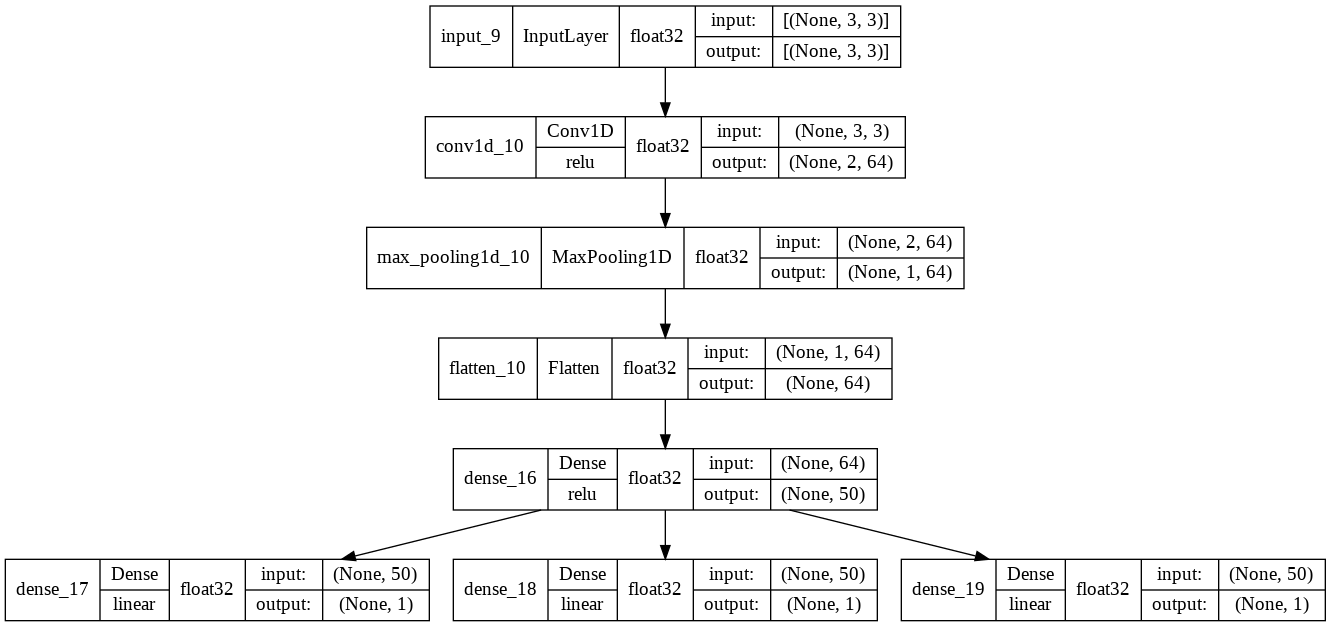

In [87]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True)

In [88]:
# separate output
_y1 = _y[:, 0].reshape((_y.shape[0], 1))
_y2 = _y[:, 1].reshape((_y.shape[0], 1))
_y3 = _y[:, 2].reshape((_y.shape[0], 1))

In [89]:
history = model.fit(x=_X, y=[_y1, _y2, _y3], verbose=0, epochs=100)

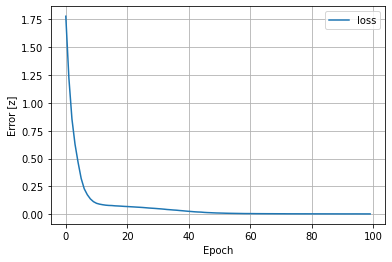

In [90]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [91]:
_y_predicted = model.predict(_X)

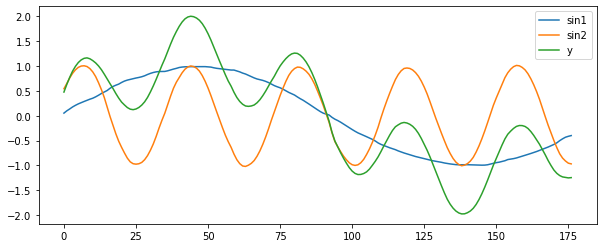

In [92]:
plt.figure(figsize=(10,4))
plt.plot(_y_predicted[0], label = 'sin1')
plt.plot(_y_predicted[1], label = 'sin2')
plt.plot(_y_predicted[2], label = 'y')
plt.legend()
plt.show()

## Multi-Step CNN Models

Ez is érdekes. Ez gyakorlatilag arról szól, hogy nem a következő, hanem a következő időpontok vektorát becsüljük.

In practice, there is little difference to the 1D CNN model in predicting a vector output that represents different output variables (as in the previous example), or a vector output that represents multiple time steps of one variable.

Nevertheless, there are subtle and important differences in the way the training data is prepared. In this section, we will demonstrate the case of developing a multi-step forecast model using a vector model.

Before we look at the specifics of the model, let’s first look at the preparation of data for multi-step forecasting.

### Data Preparation

As with one-step forecasting, a time series used for multi-step time series forecasting must be split into samples with input and output components.

Both the input and output components will be comprised of multiple time steps and may or may not have the same number of steps.

For example, given the univariate time series:

```
[10, 20, 30, 40, 50, 60, 70, 80, 90]
```

We could use the last three time steps as input and forecast the next two time steps.

The first sample would look as follows:

Input:
```
[10, 20, 30]
```

Output:
```
[40, 50]
```

The split_sequence() function below implements this behavior and will split a given univariate time series into samples with a specified number of input and output time steps.



In [93]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [94]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# choose a number of time steps
n_steps_in, n_steps_out = 3, 2

# split into samples
_X, _y = split_sequence(raw_seq, n_steps_in, n_steps_out)

# summarize the data
for i in range(len(_X)):
	print(_X[i], _y[i])

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


Now that we know how to prepare data for multi-step forecasting, let’s look at a 1D CNN model that can learn this mapping.

### Vector Output Model

The 1D CNN can output a vector directly that can be interpreted as a multi-step forecast.

This approach was seen in the previous section were one time step of each output time series was forecasted as a vector.

As with the 1D CNN models for univariate data in a prior section, the prepared samples must first be reshaped. The CNN expects data to have a three-dimensional structure of [samples, timesteps, features], and in this case, we only have one feature so the reshape is straightforward.

In [97]:
# reshape from [samples, n_lags] into [samples, n_lags, features]

n_features = 1
_X = _X.reshape((_X.shape[0], _X.shape[1], n_features))

print(_X.shape)

(5, 3, 1)


In [106]:
input_layer = tf.keras.layers.Input(shape=(n_steps_in, n_features))

cnn_layer = tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input_layer)
pool_layer = tf.keras.layers.MaxPool1D(pool_size=2)(cnn_layer)
flatten_layer = tf.keras.layers.Flatten()(pool_layer)
dense_layer = tf.keras.layers.Dense(units=50, activation='relu')(flatten_layer)
output_layer = tf.keras.layers.Dense(units=n_steps_out)(dense_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='mse')

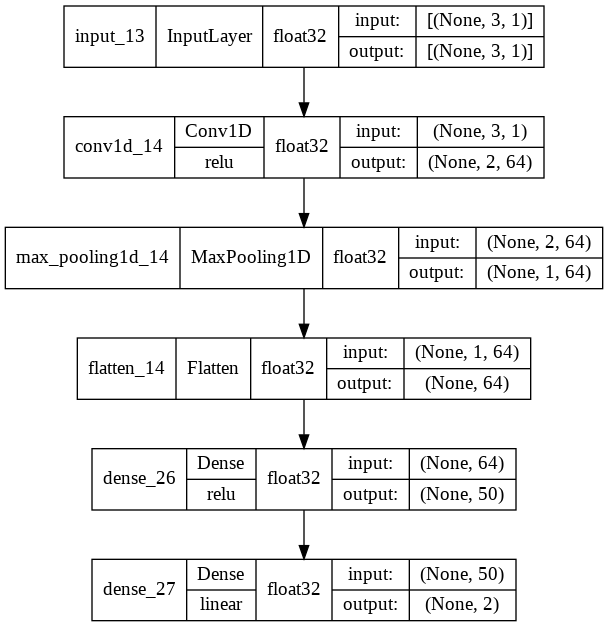

In [107]:
# model.summary()

tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True)

In [108]:
history = model.fit(x=_X, y=_y, verbose=0, epochs=100)

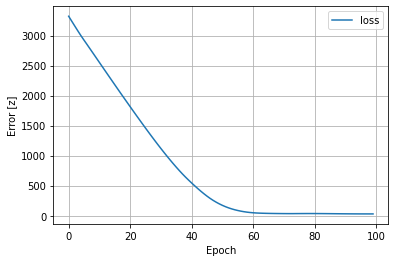

In [109]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [110]:
_y_predicted = model.predict(_X)

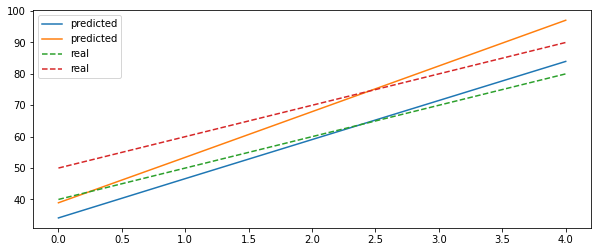

In [114]:
plt.figure(figsize=(10, 4))
plt.plot(_y_predicted, label='predicted')
plt.plot(_y, linestyle='--', label='real')
plt.legend()
plt.show()

In [116]:
# demonstrate prediction
x_input = np.array([70, 80, 90])

x_input = x_input.reshape((1, n_steps_in, n_features))

_y_predicted = model.predict(x_input, verbose=0)

_y_predicted

array([[108.86132, 126.19193]], dtype=float32)

## Conclusion

Hát sajnos az látszik, hogy a Neurális háló nagyon érzékeny a kiidnuló pontra.
Hiába sikerült mindkét esetben nagyon jó illeszkedést produkálnia, ezt két különböző súlyvektorral érte el és még az első esetében jól látszik, hogy tökéletesen lefedi a valóságot amikor extrapolláltam és a jövőbeli értékeket jeleztem vele előre, a második esetben jól látszik, hogy ez nem sikerült.

Lehetséges javaslatok:
- nullára állítani a kiinduló súlyokat
- volt egy másik ötletem is de elfelejtettem
- játszani a batch_size értékével